## Chapter 8: Tree-Based Methods

In [3]:
import numpy as np
import scipy as sp
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

from IPython.display import Image

#import StringIO, pydot
#import pydot
from io import StringIO
import pydotplus

%matplotlib inline

In [4]:
# This function creates images of tree models using pydot
# Ref.: http://nbviewer.jupyter.org/github/JWarmenhoven/ISL-python/blob/master/Notebooks/Chapter%208.ipynb
def print_tree(estimator, features, class_names=None, filled=True):
    tree = estimator
    names = features
    color = filled
    classn = class_names
    
    dot_data = StringIO()
    export_graphviz(estimator, out_file=dot_data, feature_names=features, class_names=classn, filled=filled)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return(graph)

### 8.3.1 Fitting classification trees

In [5]:
carseats_df = pd.read_csv("./data/Carseats.csv")
carseats_df.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


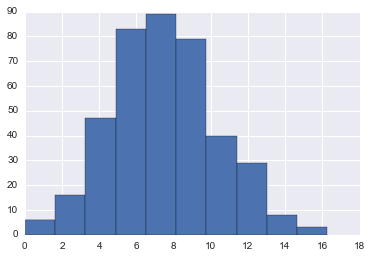

In [6]:
# Convert string variables to numeric
carseats_df["ShelveLoc"] = pd.factorize(carseats_df["ShelveLoc"])[0]
carseats_df["Urban"] = pd.factorize(carseats_df["Urban"])[0]
carseats_df["US"] = pd.factorize(carseats_df["US"])[0]
# In this data Sales is a continuos variable. 
plt.hist(carseats_df["Sales"]);

In [7]:
# We record Sales as a binary variable and add it as a new column in the data frame
carseats_df["HighSales"] = carseats_df["Sales"].map(lambda x: 0 if x<=8.0 else 1)
carseats_df.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US,HighSales
0,9.50,138,73,11,276,120,0,42,17,0,0,1
1,11.22,111,48,16,260,83,1,65,10,0,0,1
2,10.06,113,35,10,269,80,2,59,12,0,0,1
3,7.40,117,100,4,466,97,2,55,14,0,0,0
4,4.15,141,64,3,340,128,0,38,13,0,1,0


### Decision tree classifier

In [8]:
# Exclude Sales and HighSales columns. HighSales is removed because is the response variable we 
# are trying to predice. Sales is removed because it was used to generate the binary response 
# variable and so it is correlated to the response.
collist = [x for x in carseats_df.columns if x not in ["Sales", "HighSales"]]
X = carseats_df[collist].values
y = carseats_df["HighSales"].values
clf = DecisionTreeClassifier()
## We limit the tree size for cleaner visualization.
#clf = DecisionTreeClassifier(max_depth=None, max_leaf_nodes=6, max_features=3)
clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

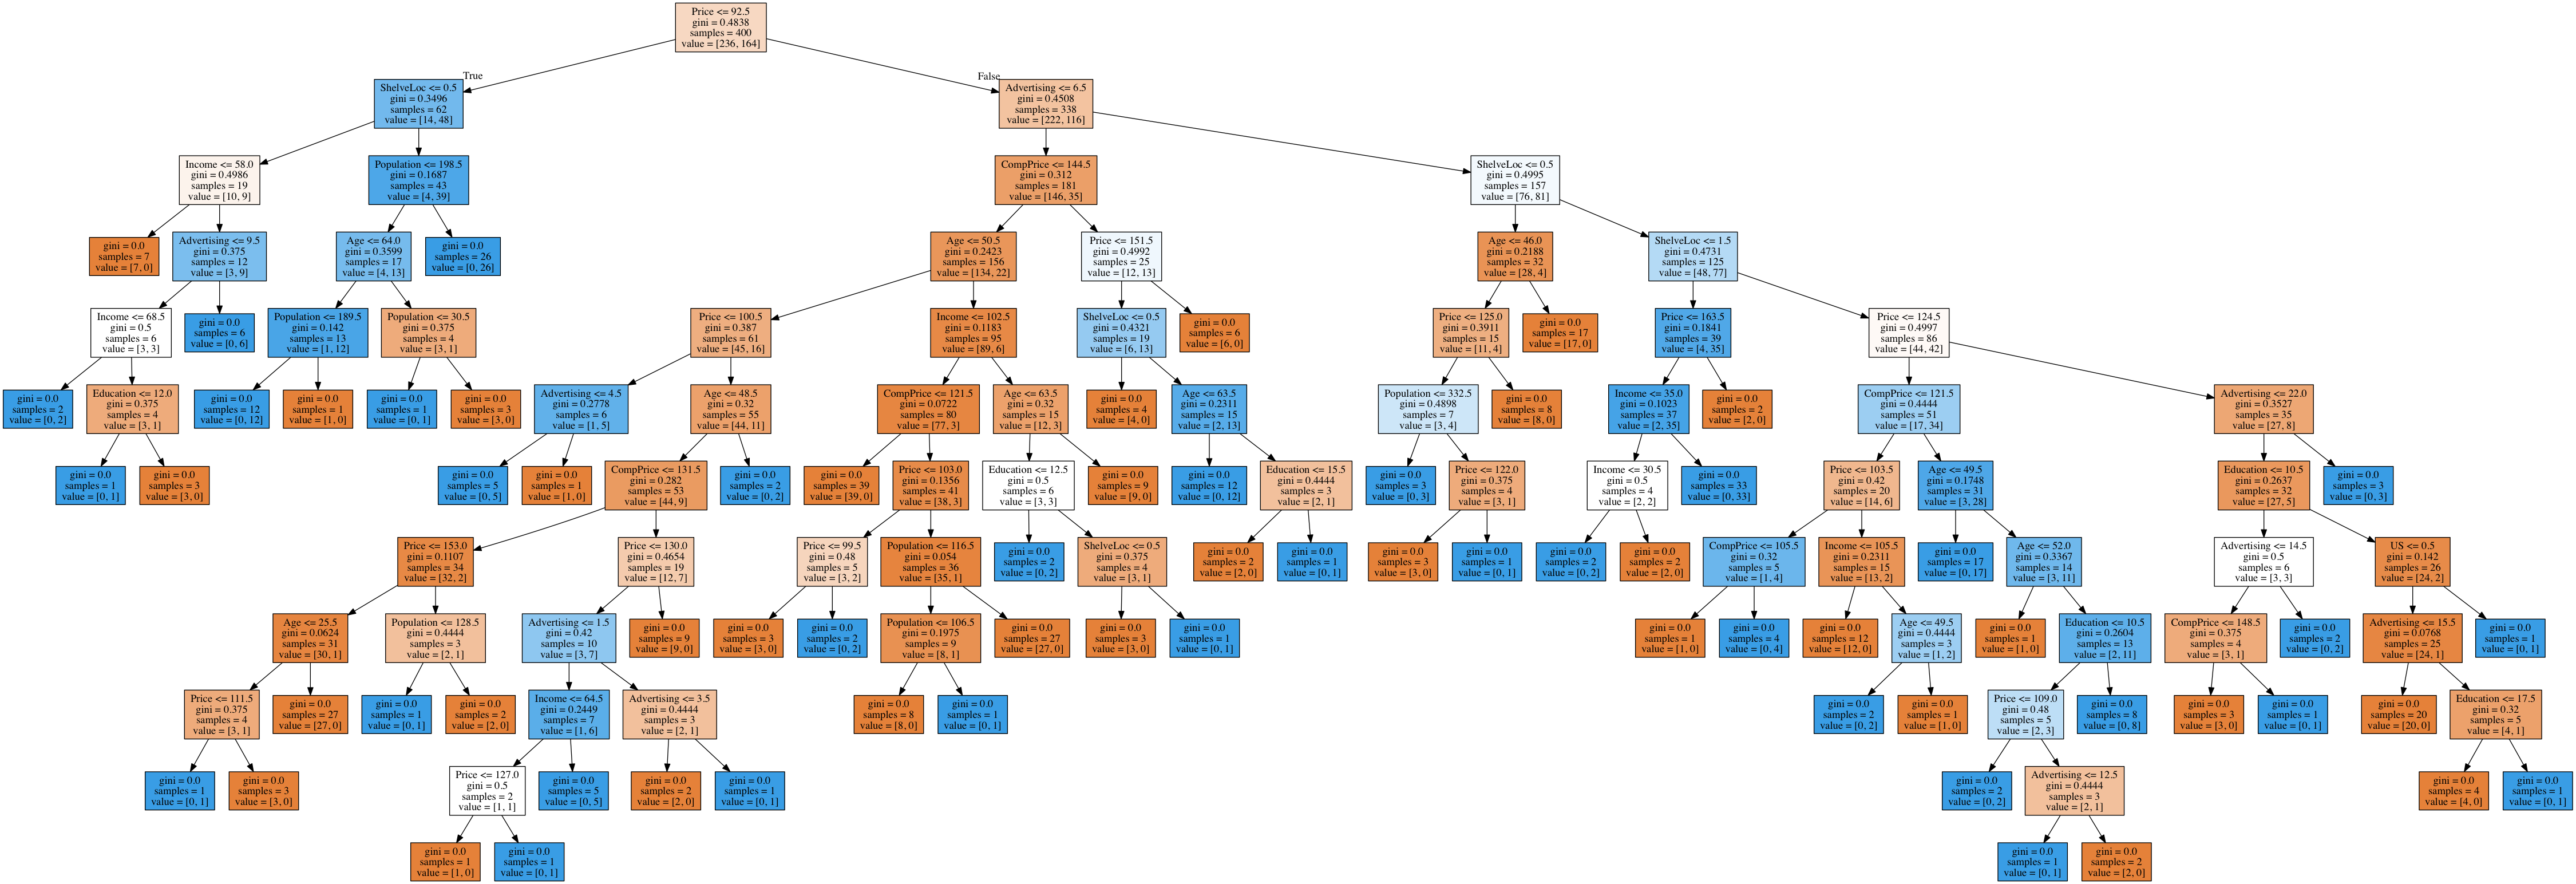

In [9]:
# Visualize the tree
graph = print_tree(clf, features=collist)
Image(graph.create_png())

In [10]:
# Evaluate a tree classifier by splitting the data into train (250) and test (150) sets
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=250, test_size=150, random_state=42)
clf = DecisionTreeClassifier()
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)
print (confusion_matrix(ytest, ypred))
print (accuracy_score(ytest, ypred))

[[59 23]
 [26 42]]
0.673333333333


Scikit-learn doesn't support prunning currently. Here, we compute trees with varing depth using training set and determine the optimal depth by k-fold cross-validation.

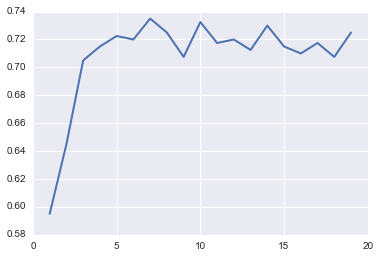

In [11]:
kfold = KFold(n=X.shape[0], n_folds=10)
max_depths = np.arange(1,20)
accs = []
for max_depth in max_depths:
    k_accs = []
    for train, test in kfold:        
        Xtrain, Xtest, ytrain, ytest = X[train], X[test], y[train], y[test]
        clf = DecisionTreeClassifier(max_depth=max_depth)
        clf.fit(Xtrain, ytrain)
        ypred = clf.predict(Xtest)
        k_accs.append(accuracy_score(ytest, ypred))
    accs.append(np.mean(k_accs))
    
plt.plot(max_depths, accs, lw=2)

Accuracy scores peak around max_depth=6.

In [12]:
# Compute a decision with max_depth=6.
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=250, test_size=150, random_state=42)
clf = DecisionTreeClassifier(max_depth=max_depth)
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)
print (confusion_matrix(ytest, ypred))
print (accuracy_score(ytest, ypred))

[[60 22]
 [19 49]]
0.726666666667


### 8.3.2 Fitting regression trees

In [13]:
boston_df = pd.read_csv('./data/Boston.csv')
boston_df.head()

,Unnamed: 0,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [14]:
boston_df.drop("Unnamed: 0", axis=1, inplace=True)
boston_df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [15]:
X = boston_df.drop("medv", axis=1).values
y = boston_df["medv"].values

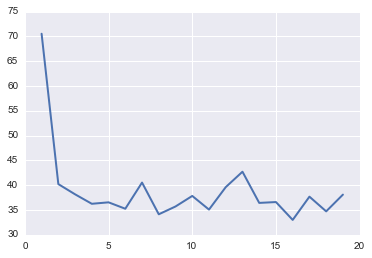

In [16]:
kfold = KFold(n=X.shape[0], n_folds=10)
max_depths = np.arange(1,20)
mses = []
for max_depth in max_depths:
    k_mses = []
    for train, test in kfold:        
        Xtrain, Xtest, ytrain, ytest = X[train], X[test], y[train], y[test]
        reg = DecisionTreeRegressor(max_depth=max_depth)
        reg.fit(Xtrain, ytrain)
        ypred = reg.predict(Xtest)
        k_mses.append(mean_squared_error(ytest, ypred))
    mses.append(np.mean(k_mses))
    
plt.plot(max_depths, mses, lw=2)

21.1916723061


/Users/neeravkharche/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


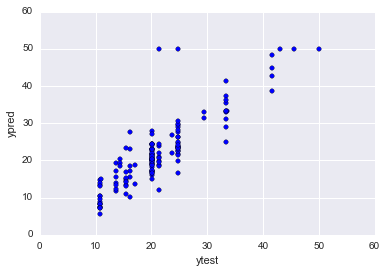

In [17]:
# Drop in the mean squared error levels off around max_depth=5.
# Now we evaluate the performace of a tree with max_depth=5
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=250, test_size=150, random_state=0)
reg = DecisionTreeRegressor(max_depth=5)
reg.fit(Xtrain, ytrain)
ypred = reg.predict(Xtest)

plt.scatter(ypred, ytest)
plt.xlabel('ytest')
plt.ylabel('ypred')

print (mean_squared_error(ytest, ypred))

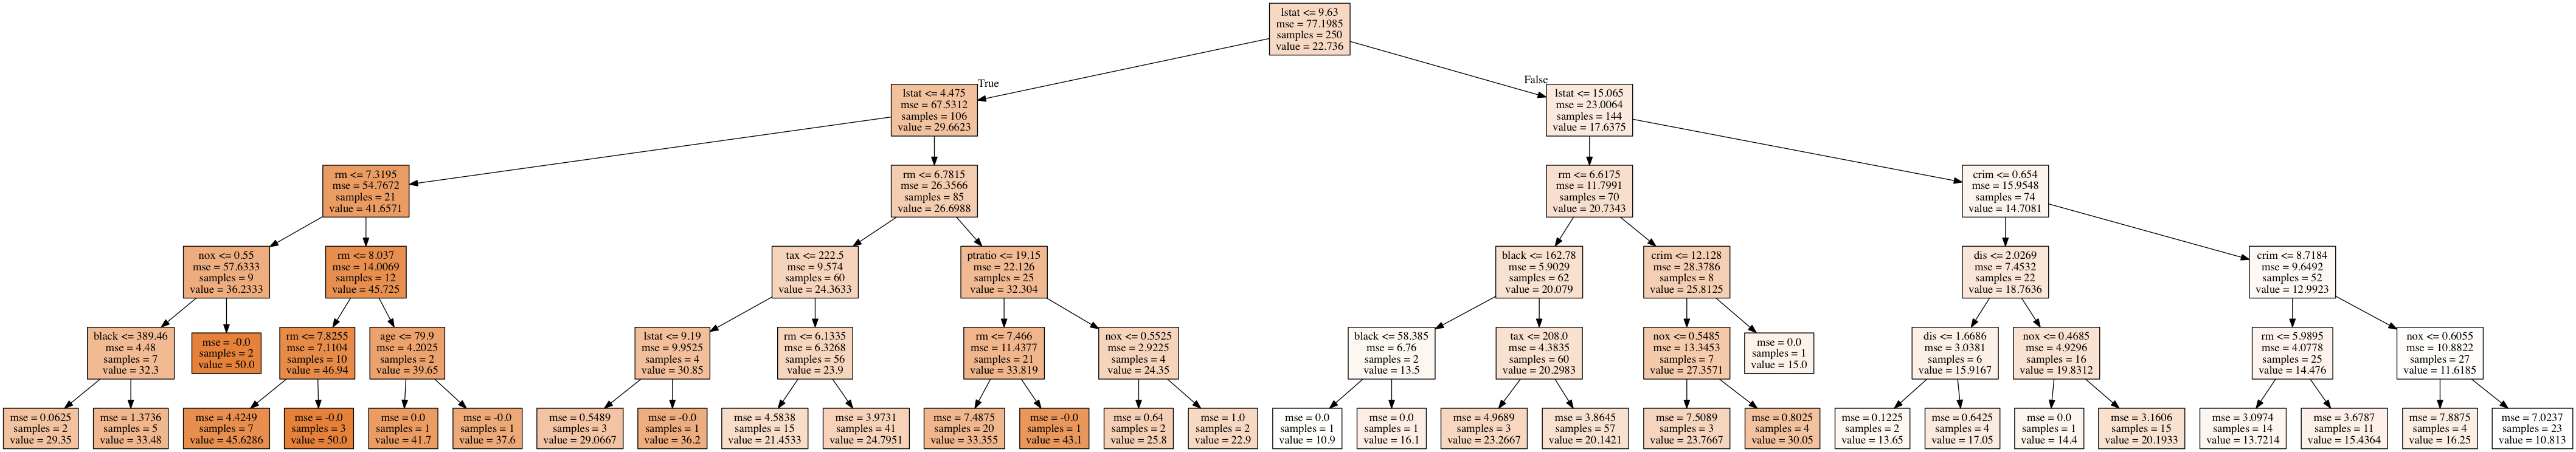

In [18]:
# Print the tree
collist = [col for col in boston_df.columns if col not in "medv"]
graph = print_tree(reg, features=collist)
Image(graph.create_png())

### 8.3.3 Bagging and random forests
Individual trees suffer from large variance. Bagging or random forest build a large number of trees and then average them out to reduce the variance. Bagging is a special case of random forest with m=p.

10.6397085739 0.81500468218


/Users/neeravkharche/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


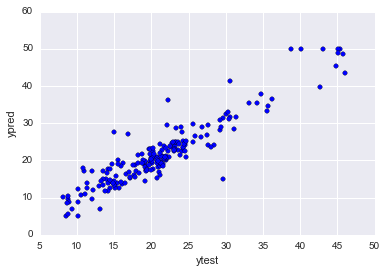

In [19]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=300, test_size=202, random_state=42)
#train_test_split(X, y, train_size=250, test_size=150, random_state=0)
reg = RandomForestRegressor(n_estimators=500, oob_score=True)
reg.fit(Xtrain, ytrain)
ypred = reg.predict(Xtest)

plt.scatter(ypred, ytest)
plt.xlabel('ytest')
plt.ylabel('ypred')

print (mean_squared_error(ytest, ypred), reg.oob_score_)

Determine the maximum number of features to use in building random forests. We use out-of-bag (oob) error to evaluate the random forest regressor.

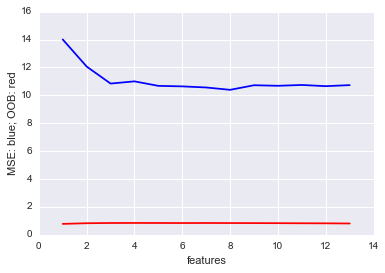

In [20]:
num_features_array = np.arange(1,14)
oob_scores = []
mses = []
for num_features in num_features_array:
    reg = RandomForestRegressor(n_estimators=500, max_features=num_features, oob_score=True)
    reg.fit(Xtrain, ytrain)
    ypred = reg.predict(Xtest)
    oob_scores.append(reg.oob_score_)
    mses.append(mean_squared_error(ytest, ypred))
    
plt.figure
plt.plot(num_features_array, oob_scores, 'r')
plt.plot(num_features_array, mses, 'b')
plt.xlabel('features')
plt.ylabel('MSE: blue; OOB: red')

### 8.3.4 Boosting
Boosting uses a large number of small trees. Each new tree added to the ensemble reduces the residual error.

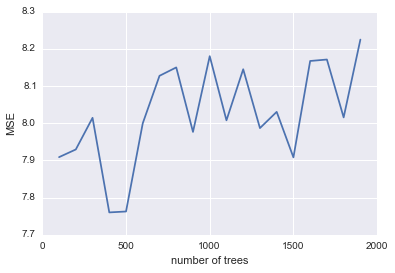

In [21]:
num_trees_arr = np.arange(100, 2000, 100)
mses = []
for num_trees in num_trees_arr:
    reg = GradientBoostingRegressor(n_estimators=num_trees)
    reg.fit(Xtrain, ytrain)
    ypred = reg.predict(Xtest)
    mses.append(mean_squared_error(ytest, ypred))
    
plt.plot(num_trees_arr, mses)
plt.xlabel("number of trees")
plt.ylabel("MSE")

zn          0.015092
indus       0.465541
chas        0.699664
rad         2.559197
nox         3.878512
black       4.499776
crim        5.424838
age         6.520241
tax         7.460238
ptratio     7.511732
dis        10.505150
rm         23.422716
lstat      27.037304
dtype: float64


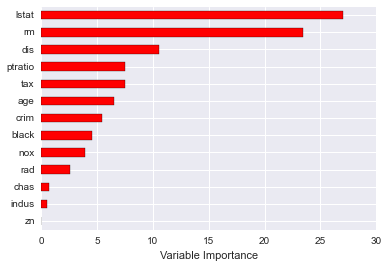

In [22]:
# Variable importance
regr = GradientBoostingRegressor(n_estimators=500, learning_rate=0.01, random_state=1)
regr.fit(Xtrain, ytrain)
feature_importance = regr.feature_importances_*100
rel_imp = pd.Series(feature_importance, index=collist).sort_values(inplace=False)
print(rel_imp)
rel_imp.T.plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None